In [6]:
!pip install scikit-learn

In [7]:
!pip install matplotlib

梯度提升回歸（Gradient Boosting Regression）

例如使用XGBoost或LightGBM來建立模型。

步驟概述
1.資料清理與前處理
2.特徵工程
3.建立梯度提升模型
4.模型訓練與評估
5.價格預測




主要步驟：
1.資料清理與前處理
2.特徵工程（缺失值填補與One-Hot Encoding）
3.XGBoost 模型建構與訓練
4.模型預測與性能評估（MAE和MSE）

xgboost

All Features Model - MAE: 3804.083543729494
All Features Model - MSE: 25035391.522164997
All Features Model - R^2: 0.8689094666218589
Selected Features Model - MAE: 5780.205184534898
Selected Features Model - MSE: 53760713.921827555
Selected Features Model - R^2: 0.7184976853043208


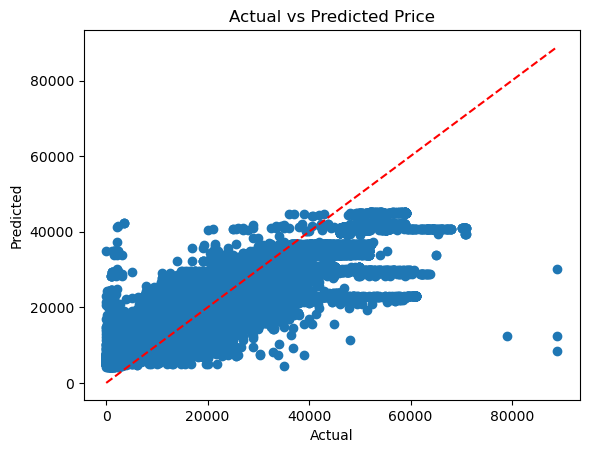

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re
import matplotlib.pyplot as plt

# 讀取資料
file_path = 'final.json'
data = pd.read_json(file_path)

# 清理欄位名稱：去除前後空白
data.columns = data.columns.str.strip()

# 定義清洗函式
def clean_capacity(value):
    if isinstance(value, str):
        match = re.search(r'\d+', value)
        return float(match.group()) if match else np.nan
    try:
        return float(value)
    except:
        return np.nan

def clean_numeric(value):
    try:
        return float(value)
    except:
        return np.nan

def clean_to_string(value):
    if isinstance(value, dict):
        return str(value)
    elif isinstance(value, list):
        return ','.join([clean_to_string(v) for v in value])
    try:
        return str(value)
    except:
        return 'Unknown'

# 將日期轉為數值（以秒數表示）
def clean_date(value):
    try:
        dt = pd.to_datetime(value, errors='coerce')
        if pd.isna(dt):
            return np.nan
        return dt.timestamp()
    except:
        return np.nan

# 清洗數值欄位（原始欄位：金額、容量、電池健康度）
for col in ['金額', '容量', '電池健康度']:
    if col in data.columns:
        data[col] = data[col].apply(clean_numeric)

# 處理日期型欄位：日期、上市日、資料抓取日
for col in ['日期', '上市日', '資料抓取日']:
    if col in data.columns:
        data[col] = data[col].apply(clean_date)

# 處理顏色欄位
if '顏色' in data.columns:
    if data['顏色'].isna().sum() / len(data) > 0.5:
        data['顏色'] = data['顏色'].fillna('Unknown')
    else:
        data['顏色'] = data['顏色'].apply(clean_to_string)

# 處理類別型欄位
categorical_cols = ['廠商', '型號', '顏色', '地區', '福利品', '配件', '全新']
label_encoders = {}

for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype(str)  # 將 object 轉為 string
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])
        label_encoders[col] = encoder

# 移除金額為 NaN 的資料
data = data[data['金額'].notna()]

# 完整特徵列表（包含所有可能出現的特徵）
full_feature_list = ['廠商', '型號', '容量', '電池健康度', '顏色', '日期', '地區', '福利品', 
                     '配件', '全新', '保固時長', '記憶體', '上市日', '資料抓取日', 
                     '抓取日建議售價', '上市日建議售價']

# 建立完整的 DataFrame，缺少的特徵填入 NaN
X_all = data.reindex(columns=full_feature_list).fillna(0)

# Selected Features：可以根據實際需要選擇特徵
selected_features = ['廠商', '型號', '容量', '電池健康度', '日期', '上市日', '資料抓取日']
X_selected = data.reindex(columns=full_feature_list).fillna(0)[selected_features]

# 目標變數
y = data['金額']

# 訓練/測試集拆分 - All Features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.15, random_state=100)

# 訓練/測試集拆分 - Selected Features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.15, random_state=100)


# 建立 XGBoost 模型
model = XGBRegressor(
    n_estimators=200,               # 樹的數量（默認100）
    learning_rate=0.01,               # 學習率，用來縮小每棵樹的影響，過小會減慢學習過程，過大可能會過擬合
    max_depth=3,                      # 樹的最大深度，影響模型的複雜度，數字越大，模型越複雜
    subsample=0.6,                    # 用來訓練每棵樹的樣本比例，過低可能會導致欠擬合，過高可能會過擬合
    colsample_bytree=0.6,             # 用來訓練每棵樹時的特徵比例，過低可能會欠擬合，過高則可能過擬合
    reg_alpha=5.0,                    # L1 正則化（Lasso），有助於特徵選擇，減少過擬合
    reg_lambda=5.0,                   # L2 正則化（Ridge），有助於減少過擬合
    enable_categorical=True,          # 訓練資料中允許處理類別型資料（對於有類別變數的資料集特別有用）
    random_state=42                   # 隨機數種子，保證重現性
)

# 訓練模型 - All Features
model.fit(X_train_all, y_train_all)
# 預測
y_pred_all = model.predict(X_test_all)


# 評估 - All Features
print(f'All Features Model - MAE: {mean_absolute_error(y_test_all, y_pred_all)}')
print(f'All Features Model - MSE: {mean_squared_error(y_test_all, y_pred_all)}')
print(f'All Features Model - R^2: {r2_score(y_test_all, y_pred_all)}')


# 訓練模型 - Selected Features
model.fit(X_train_selected, y_train_selected)

# 預測
y_pred_selected = model.predict(X_test_selected)

# 評估 - Selected Features
print(f'Selected Features Model - MAE: {mean_absolute_error(y_test_selected, y_pred_selected)}')
print(f'Selected Features Model - MSE: {mean_squared_error(y_test_selected, y_pred_selected)}')
print(f'Selected Features Model - R^2: {r2_score(y_test_selected, y_pred_selected)}')

# 視覺化
plt.scatter(y_test_selected, y_pred_selected)
plt.plot([min(y_test_selected), max(y_test_selected)], [min(y_test_selected), max(y_test_selected)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Price')
plt.show()




In [10]:
import json
import numpy as np

mae = mean_absolute_error(y_test_selected, y_pred_selected)
mse = mean_squared_error(y_test_selected, y_pred_selected)
r2 = r2_score(y_test_selected, y_pred_selected)




# 自訂 JSON 序列化函式
def json_converter(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

# 將結果儲存成 JSON 檔案
results = {
    "MAE": mae,
    "MSE": mse,
    "R^2": r2,
    "Feature Importance": dict(zip(X_train_selected.columns, model.feature_importances_))
}

# 根據模型名稱指定檔案名稱
model_name = "xgboost"  # 換成 lightgbm 或 xgboost random_forest
file_name = f"{model_name}_results.json"

# 儲存為 JSON
with open(file_name, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4, default=json_converter)

print(f"結果已儲存至 {file_name}")

結果已儲存至 xgboost_results.json


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 假設 model 已經訓練好
# 新的輸入數據（只有四個特徵）
new_data = pd.DataFrame({
    '廠商': ['apple'],
    '型號': ['iphone 13 pro max'],
    '容量': [128],
    '電池健康度': [85]
})

# 處理類別型變數（確保與訓練時一致）
new_data = pd.get_dummies(new_data, columns=['廠商', '型號'])

# 確保 new_data 的欄位與 X_train 一致
missing_cols = set(X_train_selected.columns) - set(new_data.columns)
for col in missing_cols:
    new_data[col] = 0  # 填充缺失的類別欄位

# 重新排列欄位順序以匹配訓練數據
new_data = new_data[X_train_selected.columns]

# 進行預測
predicted_price = model.predict(new_data)[0]

# 計算標準差（使用訓練誤差）

std_dev = np.std(y_test_selected - model.predict(X_test_selected))

# 預測範圍
adjusted_std_dev = std_dev * 0.5  # 減少標準差影響
lower_bound = predicted_price - adjusted_std_dev
upper_bound = predicted_price + adjusted_std_dev

# 輸出結果
print(f'Predicted Price: {predicted_price}')
print(f'Price Range: {lower_bound} - {upper_bound}')





Predicted Price: 9540.05078125
Price Range: 5874.0673828125 - 13206.0341796875


何時選擇 XGBoost 或 LightGBM？
如果你處理的數據集比較小或中等，且關心穩定性和可解釋性，XGBoost 是一個不錯的選擇。
如果你處理的是 大數據集 或者需要更快的訓練速度，並且你的特徵數量很高，則 LightGBM 會是更好的選擇，特別是在大規模數據的場景中。

模型表現解讀
MAE值小，表示預測誤差在合理範圍內，模型具有不錯的預測效果。
MSE值大，表示有些預測誤差偏大，可能受到一些極端值影響。

4. 如何評估模型結果
一旦模型訓練完成，你可以用測試集來評估模型的表現。以下是幾個常見的回歸模型評估指標：


均方誤差（MSE, Mean Squared Error）：評估模型的預測值與實際值之間的差異，數值越小越好。
決定係數（R², R-squared）：衡量模型解釋變數變異的能力，範圍是 [0, 1]，數值越接近 1，表示模型越好。
均方根誤差（RMSE, Root Mean Squared Error）：是 MSE 的平方根，能夠給出一個更具可讀性的結果。





5. 下一步
可以使用一個回歸模型（如線性回歸、隨機森林回歸等）來預測 金額，並評估其在測試集上的表現。
需要注意的是，模型可能需要進行特徵選擇（選擇與 金額 最相關的特徵）以及進行更多的調參工作來提高預測準確性。